<a href="https://colab.research.google.com/github/gndumbri/FindMyPhoto/blob/master/Final_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sources

1. https://mc.ai/tutorial-image-classification-with-keras-flow_from_directory-and-generators/

2. https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

3. https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

4. https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification/59326862#59326862

5. https://www.tensorflow.org/tutorials/images/transfer_learning

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import classification_report, roc_curve, auc
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')

Variables to use for Data Processing and Modeling

In [0]:
# predicting a single photo
preddir = '/content/drive/My Drive/pred'

# training data set
traindir = '/content/drive/My Drive/Findmyphoto/train'

# validation data set
valdir = '/content/drive/My Drive/Findmyphoto/val'

# variables to use throughout
IMG_SIZE = 160
batch_size = 32
epochs = 30

Functions

In [0]:
def show_predictions(model, preddir, IMG_SIZE, training_data, val):
    pred = ImageDataGenerator(rescale=1./255)
    pred = pred.flow_from_directory(
        preddir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=len(val.classes),
        shuffle=False
        )
    predictions = model.predict(pred, steps=1)
    preds = np.argmax(predictions,axis=1) 
    labels = (training_data.class_indices) # code from source 1
    labels = dict((v,k) for k,v in labels.items()) # code from source 1
    return [labels[k] for k in preds] # code from source 1

In [0]:
def run_model(model, train_data, val_data, batch_size, epochs):
    history = model.fit(
        train_data,
        steps_per_epoch=309//batch_size,
        epochs=epochs,
        validation_data=val_data, 
        validation_steps=118//batch_size
        )
    return history

In [0]:
def plot_confusion_matrix(IMG_SIZE, val_gen, valdir, model, 
                          prediction_data_gen, model_name):
    plt.rcParams.update({'font.size': 11})
    
    predictions = model.predict(prediction_data_gen, steps=1)
    preds = np.argmax(predictions,axis=1)
    predictions = tf.nn.softmax(predictions, axis=1)
    
    labels = (val_gen.classes)
    
    plot_labels = np.array([i for i in (val_gen.class_indices).keys()])
    
    cm = tf.math.confusion_matrix(labels, preds)

    ratio_correct = np.trace(cm)/np.sum(cm)
    ratio_incorrect = 1 - ratio_correct

    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap='Reds')
    plt.colorbar()

    ticks = np.arange(len(plot_labels))
    plt.xticks(ticks, plot_labels, rotation=90)
    plt.yticks(ticks, plot_labels)

    plt.title(f'Confusion Matrix for {model_name}')
    plt.grid(b=False)

    threshold = 4
    for i, j in itertools.product(
        range(cm.shape[0]), 
        range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i,j]),
                 horizontalalignment='center',
                 color='white' if cm[i,j] > threshold else 'black')
    
    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('True Label\naccuracy={:0.4f}; ratio_incorrect={:0.4f}'.format(
        ratio_correct, ratio_incorrect
    ))

In [0]:
def class_report(IMG_SIZE, val_gen, valdir, model, prediction_data_gen):
    predictions = model.predict(prediction_data_gen, steps=1)
    preds = np.argmax(predictions,axis=1)
    labels = (val_gen.classes)
    return pd.DataFrame.from_dict(
        classification_report(labels, preds, output_dict=True))


In [0]:
def find_my_photo(predictions, df):
    answer = df.loc[df['name'] == predictions[0], 'coord']
    return (''.join(list(answer))).replace(' ', '')

In [0]:
# adapted from source 4

def roc_curve(model, prediction_data_gen, val, model_name):
    predictions = model.predict(prediction_data_gen, steps=1)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(val, drop_first=False).values
    for i in range(33):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=(18,13))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    for i in range(33):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [0]:
def plot_metrics(history_):
    sns.set()
    plt.figure(figsize=(15,12))

    plt.subplot(1,2,1)
    plt.plot(history_.history['accuracy'], label='Training Accuracy')
    plt.plot(history_.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend(loc='best')

    plt.subplot(1,2,2)
    plt.plot(history_.history['loss'], label='Training Loss')
    plt.plot(history_.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend(loc='best')

    plt.tight_layout(pad=1)
    plt.show()


In [0]:
# won't work in Google Colab

def show_street_view(street_view):
    import webbrowser
    gmaps = 'http://maps.google.com/maps?q=&layer=c&cbll='
    return webbrowser.open_new_tab(gmaps + street_view)

In [0]:
def show_photo(images):
    plt.imread

Data Augmentation

In [0]:
# for displaying images only
show_image_gen = ImageDataGenerator(rescale=1./255)

# for Image Augmentation of training data set
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    zoom_range=0.5,
    shear_range=0.3,
    height_shift_range=.15,
    width_shift_range=.15
)

# for validation data set
val_gen = ImageDataGenerator(rescale=1./255)

# for making predictions
pred_gen = ImageDataGenerator(rescale=1./255)

Create Data Generators

In [99]:
# only for displaying photos
show_images_before = show_image_gen.flow_from_directory(
    traindir,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size,
    shuffle=False
)

show_images_after = image_gen_train.flow_from_directory(
    traindir,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size,
    shuffle=False
)

# creating training data set
train = image_gen_train.flow_from_directory(
    traindir,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size
    )

# creating validation data set
val = val_gen.flow_from_directory(
    valdir, 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size
    )

# to be used later for assessing model
prediction_data_gen = pred_gen.flow_from_directory(
    valdir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=len(val.classes),
    shuffle=False
    )

Found 309 images belonging to 33 classes.
Found 309 images belonging to 33 classes.
Found 309 images belonging to 33 classes.
Found 118 images belonging to 33 classes.
Found 118 images belonging to 33 classes.


In [0]:
display_images, _ = next(show_images_before)

First I created a model from scratch called "Model A"

In [0]:
model_a = Sequential([
        Conv2D(128, (2,2), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(256, (2,2), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.4),
        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.3),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(32, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.1),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(33)
])

model_a.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [79]:
history_a = run_model(model_a, train, val, batch_size, 40)

Epoch 1/40
9/9 [==============================] - 9s 982ms/step - loss: 3.4863 - accuracy: 0.0397 - val_loss: 3.4755 - val_accuracy: 0.0312
Epoch 2/40
9/9 [==============================] - 8s 892ms/step - loss: 3.4552 - accuracy: 0.0397 - val_loss: 3.4369 - val_accuracy: 0.0833
Epoch 3/40
9/9 [==============================] - 9s 956ms/step - loss: 3.4305 - accuracy: 0.0578 - val_loss: 3.4435 - val_accuracy: 0.1042
Epoch 4/40
9/9 [==============================] - 8s 933ms/step - loss: 3.4244 - accuracy: 0.0397 - val_loss: 3.4075 - val_accuracy: 0.1042
Epoch 5/40
9/9 [==============================] - 9s 1s/step - loss: 3.3400 - accuracy: 0.1083 - val_loss: 3.2676 - val_accuracy: 0.0729
Epoch 6/40
9/9 [==============================] - 9s 963ms/step - loss: 3.2949 - accuracy: 0.0590 - val_loss: 3.2965 - val_accuracy: 0.1875
Epoch 7/40
9/9 [==============================] - 9s 950ms/step - loss: 3.1745 - accuracy: 0.1372 - val_loss: 3.0274 - val_accuracy: 0.1771
Epoch 8/40
9/9 [=======

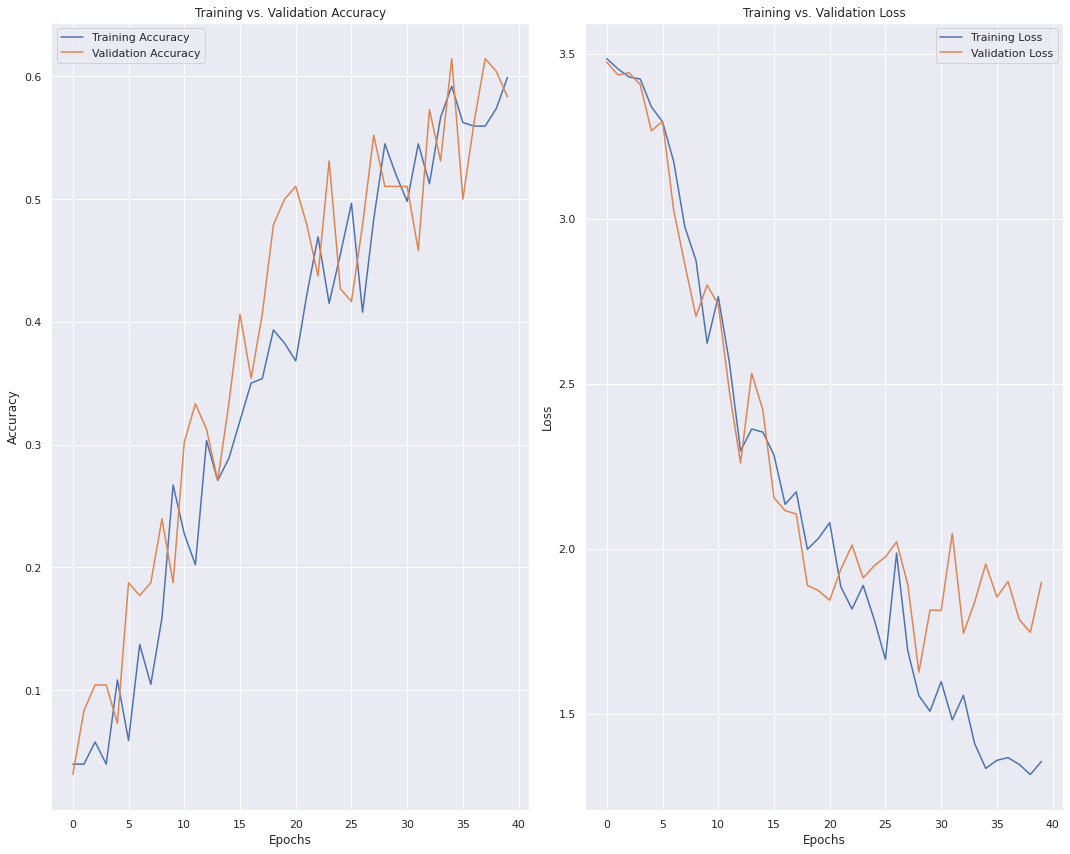

In [80]:
plot_metrics(history_a)

Transfer Learning with MobileNet

In [66]:
mobilenet_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet')

mobilenet_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
mobile_model = tf.keras.Sequential([
        mobilenet_model,
        Dropout(0.7),
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dense(33)
])

learning_rate = 0.0001

mobile_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [75]:
history_mobile = run_model(mobile_model, train, val, batch_size, 15)

Epoch 1/15
9/9 [==============================] - 9s 995ms/step - loss: 3.2368 - accuracy: 0.1841 - val_loss: 2.2344 - val_accuracy: 0.5104
Epoch 2/15
9/9 [==============================] - 8s 855ms/step - loss: 1.6166 - accuracy: 0.6209 - val_loss: 1.3425 - val_accuracy: 0.6562
Epoch 3/15
9/9 [==============================] - 8s 894ms/step - loss: 1.0125 - accuracy: 0.7329 - val_loss: 0.8842 - val_accuracy: 0.7604
Epoch 4/15
9/9 [==============================] - 8s 928ms/step - loss: 0.5315 - accuracy: 0.8773 - val_loss: 0.6210 - val_accuracy: 0.8333
Epoch 5/15
9/9 [==============================] - 8s 916ms/step - loss: 0.3845 - accuracy: 0.8819 - val_loss: 0.6405 - val_accuracy: 0.7917
Epoch 6/15
9/9 [==============================] - 8s 854ms/step - loss: 0.3174 - accuracy: 0.9206 - val_loss: 0.6668 - val_accuracy: 0.8021
Epoch 7/15
9/9 [==============================] - 8s 943ms/step - loss: 0.3240 - accuracy: 0.9242 - val_loss: 0.5251 - val_accuracy: 0.8333
Epoch 8/15
9/9 [====

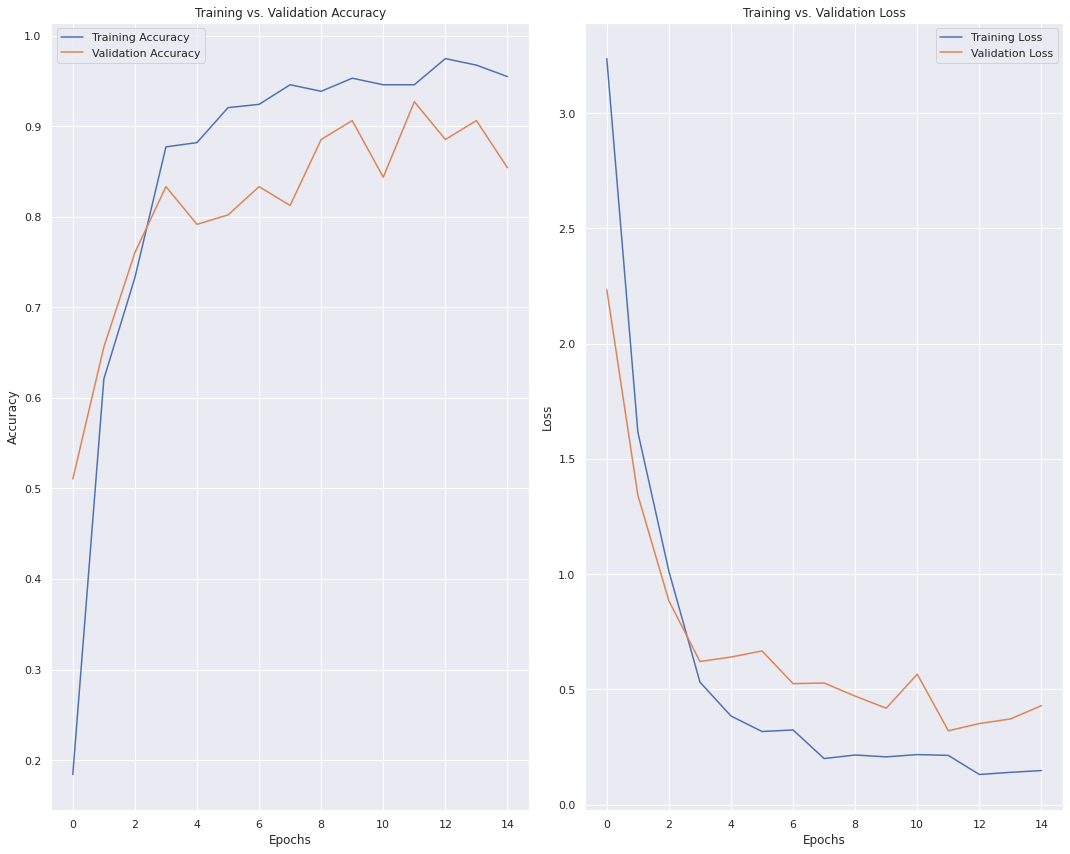

In [76]:
plot_metrics(history_mobile)

Transfer Learning with ResNet

In [81]:
resnet_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet')

94674944/94668760 [==============================] - 2s 0us/step


In [0]:
resnet_model.trainable=False

In [0]:
res_model = tf.keras.Sequential([
                    resnet_model,
                    Dropout(0.7),
                    GlobalAveragePooling2D(),
                    Dense(33)
                    ])

res_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [86]:
history_res = run_model(res_model, train, val, batch_size, epochs)

Epoch 1/30
9/9 [==============================] - 9s 1s/step - loss: 4.0118 - accuracy: 0.1083 - val_loss: 3.3111 - val_accuracy: 0.1771
Epoch 2/30
9/9 [==============================] - 9s 991ms/step - loss: 2.7809 - accuracy: 0.2996 - val_loss: 2.4321 - val_accuracy: 0.3229
Epoch 3/30
9/9 [==============================] - 8s 847ms/step - loss: 2.1317 - accuracy: 0.3827 - val_loss: 1.7490 - val_accuracy: 0.4896
Epoch 4/30
9/9 [==============================] - 9s 994ms/step - loss: 1.5399 - accuracy: 0.5235 - val_loss: 1.3687 - val_accuracy: 0.6042
Epoch 5/30
9/9 [==============================] - 8s 875ms/step - loss: 1.1862 - accuracy: 0.6679 - val_loss: 1.2013 - val_accuracy: 0.6562
Epoch 6/30
9/9 [==============================] - 9s 952ms/step - loss: 1.0609 - accuracy: 0.6667 - val_loss: 1.1765 - val_accuracy: 0.6562
Epoch 7/30
9/9 [==============================] - 8s 935ms/step - loss: 0.8731 - accuracy: 0.7581 - val_loss: 1.0078 - val_accuracy: 0.6979
Epoch 8/30
9/9 [=======

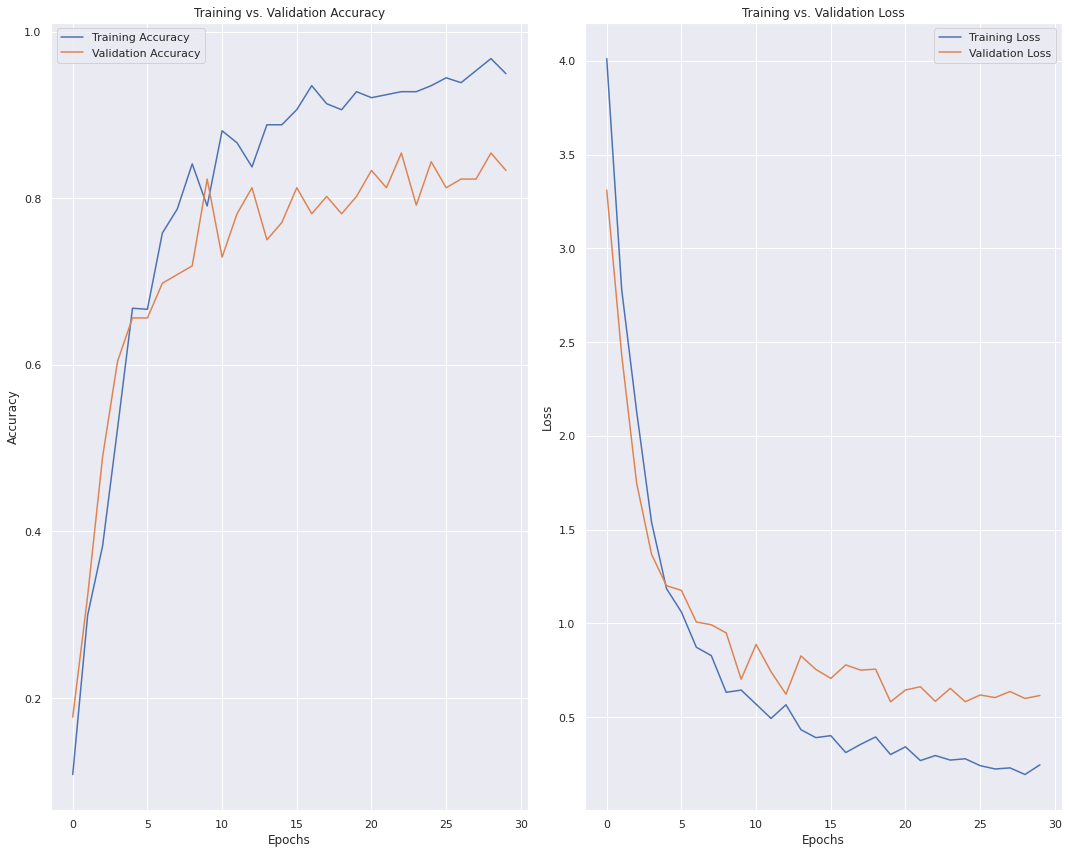

In [87]:
plot_metrics(history_res)

Assessing Models

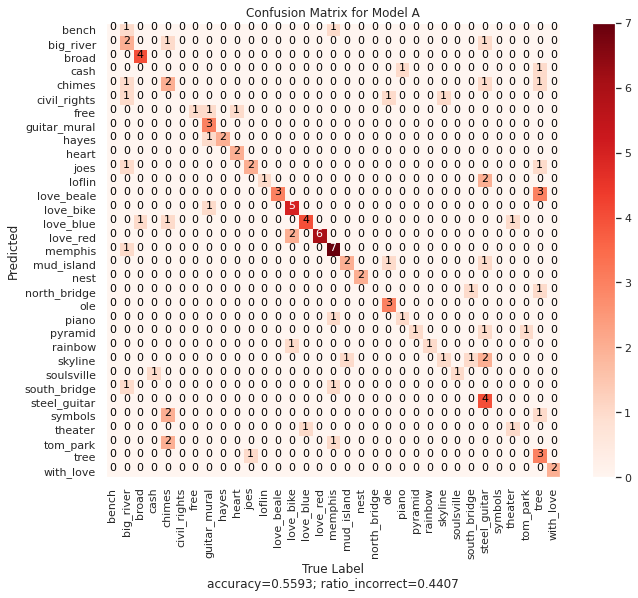

In [90]:
plot_confusion_matrix(IMG_SIZE, val, valdir, model_a, 
                      prediction_data_gen, 'Model A')

In [92]:
class_report(IMG_SIZE, val, valdir, model_a, prediction_data_gen)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,accuracy,macro avg,weighted avg
precision,0.0,0.250000,0.800000,0.0,0.250000,0.0,1.000000,0.500000,1.000000,0.666667,0.666667,1.000000,1.000000,0.625000,0.800000,1.000000,0.636364,0.666667,1.0,0.0,0.60,0.5,1.000000,1.000000,0.500000,1.000000,0.0,0.333333,0.0,0.5,0.0,0.272727,1.0,0.559322,0.562649,0.599846
recall,0.0,0.500000,1.000000,0.0,0.400000,0.0,0.333333,1.000000,0.666667,1.000000,0.500000,0.333333,0.500000,0.833333,0.571429,0.750000,0.875000,0.500000,1.0,0.0,1.00,0.5,0.333333,0.500000,0.200000,0.500000,0.0,1.000000,0.0,0.5,0.0,0.750000,1.0,0.559322,0.516558,0.559322
f1-score,0.0,0.333333,0.888889,0.0,0.307692,0.0,0.500000,0.666667,0.800000,0.800000,0.571429,0.500000,0.666667,0.714286,0.666667,0.857143,0.736842,0.571429,1.0,0.0,0.75,0.5,0.500000,0.666667,0.285714,0.666667,0.0,0.500000,0.0,0.5,0.0,0.400000,1.0,0.559322,0.495457,0.535155
support,2.0,4.000000,4.000000,2.0,5.000000,3.0,3.000000,3.000000,3.000000,2.000000,4.000000,3.000000,6.000000,6.000000,7.000000,8.000000,8.000000,4.000000,2.0,2.0,3.00,2.0,3.000000,2.000000,5.000000,2.000000,2.0,4.000000,3.0,2.0,3.0,4.000000,2.0,0.559322,118.000000,118.000000


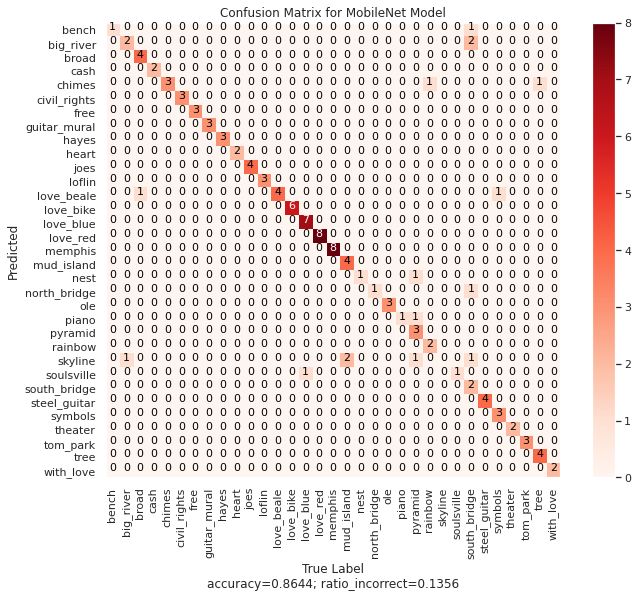

In [93]:
plot_confusion_matrix(IMG_SIZE, val, valdir, mobile_model, 
                      prediction_data_gen, 'MobileNet Model')

In [94]:
class_report(IMG_SIZE, val, valdir, mobile_model, prediction_data_gen)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,accuracy,macro avg,weighted avg
precision,1.000000,0.666667,0.800000,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,0.875000,1.0,1.0,0.666667,1.000000,1.000000,1.0,1.000000,0.500000,0.666667,0.0,1.000000,0.285714,1.0,0.750000,1.0,1.0,0.800000,1.0,0.864407,0.879113,0.877230
recall,0.500000,0.500000,1.000000,1.0,0.60,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.666667,1.0,1.000000,1.0,1.0,1.000000,0.500000,0.500000,1.0,0.500000,1.000000,1.000000,0.0,0.500000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,0.864407,0.856566,0.864407
f1-score,0.666667,0.571429,0.888889,1.0,0.75,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.800000,1.0,0.933333,1.0,1.0,0.800000,0.666667,0.666667,1.0,0.666667,0.666667,0.800000,0.0,0.666667,0.444444,1.0,0.857143,1.0,1.0,0.888889,1.0,0.864407,0.840428,0.850908
support,2.000000,4.000000,4.000000,2.0,5.00,3.0,3.0,3.0,3.0,2.0,4.0,3.0,6.000000,6.0,7.000000,8.0,8.0,4.000000,2.000000,2.000000,3.0,2.000000,3.000000,2.000000,5.0,2.000000,2.000000,4.0,3.000000,2.0,3.0,4.000000,2.0,0.864407,118.000000,118.000000


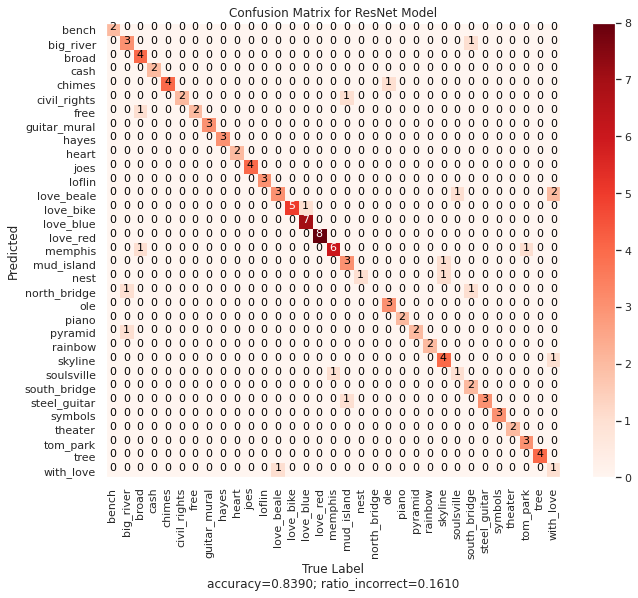

In [95]:
plot_confusion_matrix(IMG_SIZE, val, valdir, res_model, 
                      prediction_data_gen, "ResNet Model")

In [96]:
class_report(IMG_SIZE, val, valdir, res_model, prediction_data_gen)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,accuracy,macro avg,weighted avg
precision,1.0,0.600000,0.666667,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,0.75,1.000000,0.875000,1.0,0.857143,0.600000,1.000000,0.0,0.750000,1.0,1.000000,1.0,0.666667,0.5,0.500000,1.000000,1.0,1.0,0.750000,1.0,0.250000,0.838983,0.841378,0.858323
recall,1.0,0.750000,1.000000,1.0,0.800000,0.666667,0.666667,1.0,1.0,1.0,1.0,1.0,0.50,0.833333,1.000000,1.0,0.750000,0.750000,0.500000,0.0,1.000000,1.0,0.666667,1.0,0.800000,0.5,1.000000,0.750000,1.0,1.0,1.000000,1.0,0.500000,0.838983,0.831313,0.838983
f1-score,1.0,0.666667,0.800000,1.0,0.888889,0.800000,0.800000,1.0,1.0,1.0,1.0,1.0,0.60,0.909091,0.933333,1.0,0.800000,0.666667,0.666667,0.0,0.857143,1.0,0.800000,1.0,0.727273,0.5,0.666667,0.857143,1.0,1.0,0.857143,1.0,0.333333,0.838983,0.822122,0.836498
support,2.0,4.000000,4.000000,2.0,5.000000,3.000000,3.000000,3.0,3.0,2.0,4.0,3.0,6.00,6.000000,7.000000,8.0,8.000000,4.000000,2.000000,2.0,3.000000,2.0,3.000000,2.0,5.000000,2.0,2.000000,4.000000,3.0,2.0,3.000000,4.0,2.000000,0.838983,118.000000,118.000000


Predictions

In [97]:
location_1 = show_predictions(model_a, preddir, IMG_SIZE, train, val)
location_2 = show_predictions(mobile_model, preddir, IMG_SIZE, train, val)
location_3 = show_predictions(res_model, preddir, IMG_SIZE, train, val)

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


Getting lat/long for image

In [0]:
find_my_photo(location_1, pd.read_csv(r'/content/drive/My Drive/key.csv')).replace(' ', '')

'35.129059,-90.075649'

In [0]:
find_my_photo(location_2, pd.read_csv(r'/content/drive/My Drive/key.csv')).replace(' ', '')

'35.132173,-90.066536'

In [0]:
find_my_photo(location_3, pd.read_csv(r'/content/drive/My Drive/key.csv')).replace(' ', '')

'35.145345,-90.058976'

All found the right image, since mobile_model had best accuracy, I will use that result for the image retrieval

In [0]:
street_view = find_my_photo(location_2, pd.read_csv(r'/content/drive/My Drive/key.csv')).replace(' ', '')

In [0]:
street_view

'35.132173,-90.066536'